<a href="https://colab.research.google.com/github/Loinen/ml_labs/blob/main/ml_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПОСТРОЕНИЕ ПРЕДСКАЗАТЕЛЬНОЙ МОДЕЛИ ВОЗНИКНОВЕНИЯ ИНСУЛЬТА

В данной работе будет построена предсказательная модель возникновения инсульта на основе данных о [пациентах](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) c kaggle.

# 1. Загрузка данных и библиотек

In [579]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel

import plotly.graph_objs as go

%matplotlib inline

dataset = pd.read_csv("stroke_data.csv")
print(dataset.shape)

(5110, 12)


# 2. Анализ датасета

1.   id: уникальный идентификатор
2.   gender: Male, Female, Other
3.   age: возраст пациента
4.   hypertension: 0, если у пациента нет артериальной гипертензии, 1, если есть
5.   heart_disease: 0, если у пациента нет сердечных заболеваний, 1, если есть
6.   ever_married: No или Yes
7.   work_type: children, Govt_jov, Never_worked, Private или Self-employed - тип занятости
8.   Residence_type: Rural - Сельский или Urban - Городской
9.   avg_gluosis_level: средний уровень глюкозы в крови
10.  bmi: индекс массы тела
11.  smoking_status: статус курения - formerly smoked - «ранее курил», never smoked, smokes или Unknown
12.  stroke: 1, если у пациента был инсульт, или 0, если нет.


In [580]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [581]:
dataset.drop(columns=['id'], axis = 1, inplace = True)
dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [582]:
print(dataset.value_counts("gender")) # f - 2994, m - 2115, other - 1
print("\n", dataset.value_counts("hypertension")) # 0 - 4612, 1 - 498
print("\n",dataset.value_counts("heart_disease")) # 0 - 4834, 1 - 276
print("\n",dataset.value_counts("ever_married")) # y - 3353, n - 1757
print("\n",dataset.value_counts("work_type")) # Private - 2925, Self-employed - 819, children - 687, Govt_job - 657, Never_worked - 22
print("\n",dataset.value_counts("Residence_type")) #Urban - 2596, Rural - 2514
print("\n",dataset.value_counts("smoking_status")) # never smoked - 1892, Unknown - 1544, formerly smoked - 885, smokes - 789
print("\n",dataset.value_counts("stroke")) # 0 - 4861, 1 - 249

gender
Female    2994
Male      2115
Other        1
dtype: int64

 hypertension
0    4612
1     498
dtype: int64

 heart_disease
0    4834
1     276
dtype: int64

 ever_married
Yes    3353
No     1757
dtype: int64

 work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
dtype: int64

 Residence_type
Urban    2596
Rural    2514
dtype: int64

 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
dtype: int64

 stroke
0    4861
1     249
dtype: int64


In [583]:
child = dataset.loc[dataset['age'] <= 14]
#print(child.value_counts("work_type")) 
st = child.loc[dataset['stroke'] == 1]
print(st.age) 
# у нас есть достаточно много строк, где возраст явно с ошибками, но судя по worktype большинство из них дети
print("диабетики:", len(dataset.avg_glucose_level.loc[dataset['avg_glucose_level'] >= 125]))
# avg gl - 70 mg/dl - 100 mg/dl  - normal, до 70 - hypoglycemia, от 100 до 125 - prediabetic, до 300 - diabetic
print("гипокликемия:", len(dataset.avg_glucose_level.loc[dataset['avg_glucose_level'] <= 70]))

print(dataset['bmi'].loc[dataset['bmi'] >= 60]) 

# bmi - under_weight до 18.5, normal <25, overweight, <30, obese 40
# у нас есть 13 человек с bmi больше 60 - это может быть вес от 135кг (если 150 см = 60 имт) до 200кг (181кг\150см = 78 имт)
print(dataset.loc[dataset['bmi'] <= 16].value_counts("stroke")) 
# Низкие значения имт - в основном у детей, для них норма ниже

162     1.32
245    14.00
Name: age, dtype: float64
диабетики: 1000
гипокликемия: 756
270     60.9
358     64.8
466     60.2
544     71.9
928     78.0
1559    66.8
2128    97.6
2764    63.3
2840    61.2
3825    61.6
4188    64.4
4209    92.0
4838    60.9
Name: bmi, dtype: float64
stroke
0    92
dtype: int64


stroke (249, 11) no_stroke (4861, 11)


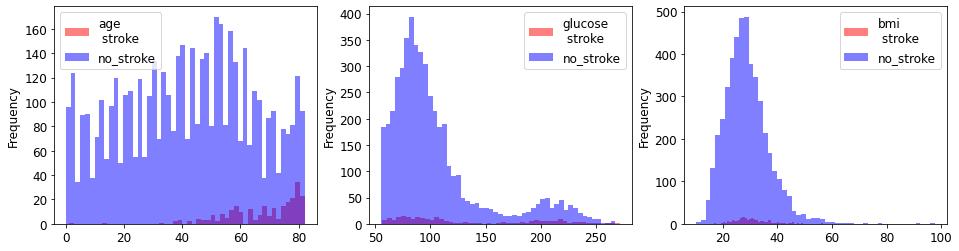

In [584]:
stroke = dataset[dataset.stroke == 1]
no_stroke = dataset[dataset.stroke == 0]
print("stroke", stroke.shape, "no_stroke", no_stroke.shape)

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

stroke["age"].plot.hist(alpha=0.5,color='red',bins=50, ax=axs[0])
no_stroke["age"].plot.hist(alpha=0.5,color='blue',bins=50, ax=axs[0])
axs[0].legend(['age\n stroke','no_stroke'])

stroke["avg_glucose_level"].plot.hist(alpha=0.5,color='red',bins=50, ax=axs[1])
no_stroke["avg_glucose_level"].plot.hist(alpha=0.5,color='blue',bins=50, ax=axs[1])
axs[1].legend(['glucose\n stroke','no_stroke'])

stroke["bmi"].plot.hist(alpha=0.5,color='red',bins=50, ax=axs[2])
no_stroke["bmi"].plot.hist(alpha=0.5,color='blue',bins=50, ax=axs[2])
axs[2].legend(['bmi\n stroke','no_stroke'])

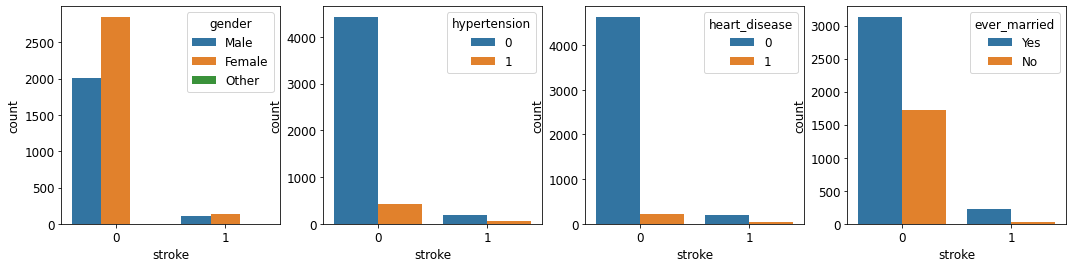

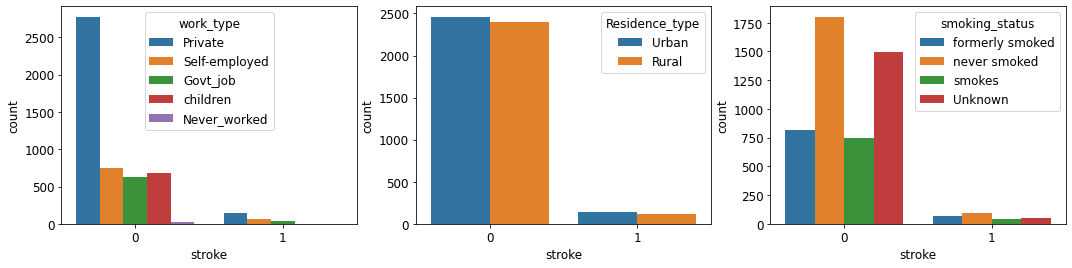

In [585]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))
sns.countplot(x="stroke",data=dataset,hue='gender', ax=axs[0])
sns.countplot(x="stroke",data=dataset,hue='hypertension', ax=axs[1])
sns.countplot(x="stroke",data=dataset,hue='heart_disease', ax=axs[2])
sns.countplot(x="stroke",data=dataset,hue='ever_married', ax=axs[3])
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))
sns.countplot(x="stroke",data=dataset,hue='work_type', ax=axs[0])
sns.countplot(x="stroke",data=dataset,hue='Residence_type', ax=axs[1])
sns.countplot(x="stroke",data=dataset,hue='smoking_status', ax=axs[2])

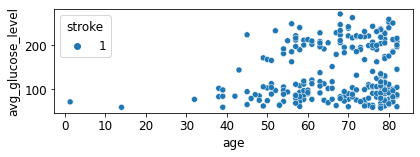

In [586]:
plt.subplot(2,1,2)
sns.scatterplot(x=stroke['age'],y=stroke['avg_glucose_level'],hue=stroke['stroke'])
plt.tight_layout()
plt.show()

In [587]:
dataset.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


# 3. Предобработка данных
Видно, что у нас есть пропуски в bmi, а также есть пациенты, у которых неизвестен статус курения. Необходимо обработать эти значения, а также категориальные признаки - age, smoking_status, work_type.
Бинарные признаки - hypertension, heart_disease, Residence_type, ever_married, gender (other всего один, можно его отбросить).
Столбец id отбросим. 
Признаки age, work_type, avg_glucose_level, bmi можно преобразовать. Для bmi можно обозначить норму, неизвестный статус и превышение нормы. Желательно, чтобы в обучающую выборку попали хотя бы несколько пациентов, у которых есть статус Never_worked, а также обязательно - часть тех, у кого был инсульт и хотя бы немного с 0 для heart_disease и hypertension




(5110, 11)
gender
Female    2994
Male      2115
dtype: int64
(5109, 11)


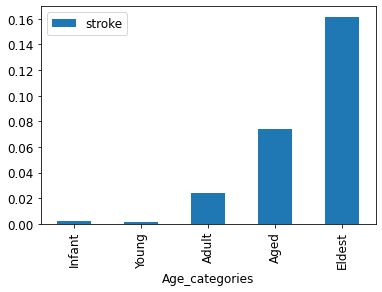

In [588]:
# Удалим лишнего пациента с "другим" полом 
print(dataset.shape)
dataset = dataset.drop(np.where(dataset['gender'] == "Other")[0])
print(dataset.value_counts("gender"))
print(dataset.shape)

# Преобразуем возраст в категориальный признак. 
def process_age(df, cut_points, label_names):
    df['age'] = df['age'].replace(np.NaN, -0.5) #fillna
    df['Age_categories'] = pd.cut(df['age'], bins=cut_points, labels=label_names)
    return df

# Нас в основном интересуют пациенты с возрастом от 35-55 до 80. 
cut_points = [0, 18, 35, 55, 65, 100]
label_names = ["Infant", "Young", "Adult", "Aged", "Eldest"]
dataset = process_age(dataset, cut_points, label_names)

age_cat_pivot = dataset.pivot_table(index="Age_categories",values="stroke")
age_cat_pivot.plot.bar()
plt.show()

In [589]:
def create_dummies(df, column_name):
    dum = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dum],axis=1)
    return df

dataset = create_dummies(dataset, "hypertension")
dataset = create_dummies(dataset, "heart_disease")
dataset = create_dummies(dataset, "Residence_type")
dataset = create_dummies(dataset, "gender")

dataset = create_dummies(dataset, "work_type")
dataset = create_dummies(dataset, "Age_categories")

In [590]:
dataset = dataset.drop(columns=['gender', 'ever_married', "work_type", "Age_categories", "Residence_type", "smoking_status", "hypertension", "heart_disease"], axis=1)

In [591]:
miss_bmi = dataset[dataset.bmi.isna()]
print("missing:", len(miss_bmi))
print("missing with stroke:", len(miss_bmi[miss_bmi.stroke == 1]))
print("В наборе данных у 40 из 249 пациентов с инсультом неизвестен ИМТ")

missing: 201
missing with stroke: 40
В наборе данных у 40 из 249 пациентов с инсультом неизвестен ИМТ


In [592]:
# пробуем предсказать имт, вместо медианы\среднего
data = dataset.copy()
data = data[~data.bmi.isna()]
print(data.shape)
y = data['bmi']

data = data[['hypertension_0', 'hypertension_1', 'avg_glucose_level', 'work_type_children', 
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged', 'Age_categories_Eldest']]

(4908, 22)


In [593]:
from sklearn.ensemble import GradientBoostingRegressor

# у нас всего 249 пациентов с инсультом из 5к. все они находятся в начале датасета
x_train, x_test, y_train, y_test = train_test_split(data, y, train_size=0.8, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) 

model = Pipeline( steps=[ ('scale',StandardScaler()),
                          ('lr',GradientBoostingRegressor(random_state=42))])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Предсказанные значения:\n', np.around(list(y_pred[:50]), 1))
print('Истинные значения:\n', np.around(list(y_test[:50]), 1))

(3926, 9) (982, 9) (3926,) (982,)
Предсказанные значения:
 [29.5 30.8 30.1 29.1 30.9 28.2 29.5 28.2 30.5 25.7 29.3 28.8 30.8 29.
 30.2 39.9 28.7 29.3 30.9 30.9 30.9 30.9 35.3 30.9 30.5 30.6 30.4 26.3
 27.6 29.2 33.6 29.1 33.8 29.1 19.7 29.9 29.9 30.9 31.9 30.8 30.7 32.7
 19.7 29.8 19.7 29.3 20.3 29.8 29.  29. ]
Истинные значения:
 [32.3 31.4 32.1 25.3 22.2 20.1 23.2 30.3 24.8 21.2 32.  24.4 26.4 16.9
 30.5 35.1 23.6 35.3 32.4 22.7 23.1 24.1 38.9 39.1 17.3 33.7 37.7 22.6
 36.4 29.2 28.4 28.4 24.6 46.5 18.4 35.5 27.9 21.5 24.1 44.  28.1 37.4
 27.5 52.8 20.5 29.6 18.6 37.  41.3 43. ]


In [594]:
from sklearn.metrics import accuracy_score, r2_score

train = pd.concat([x_train,y_train],axis=1)
test = pd.concat([x_test,y_test],axis=1)
y_pred = test.copy()

bmi_mean = np.mean(train['bmi'])
y_pred['bmi'] = bmi_mean
print('Model score:', model.score(x_test, y_test))
print('Mean score: ', r2_score(y_test, y_pred.bmi)) # Model score: 0.24334161688879252
# видно, что модель дает хоть и не очень точные, но достаточно качественные значения, в отличие от усреднения

Model score: 0.24334161688879252
Mean score:  -0.0011478514902276693


In [595]:
# Теперь предскажем имт для NAN
model = Pipeline( steps=[ ('scale',StandardScaler()),
                          ('lr',GradientBoostingRegressor(random_state=42))])
model.fit(data, y)

X = miss_bmi[['hypertension_0', 'hypertension_1','avg_glucose_level', 'work_type_children', 
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged', 'Age_categories_Eldest']]
y_pred = model.predict(X)
dataset = dataset.copy()
dataset.loc[miss_bmi.index,'bmi'] = pd.Series(y_pred,index=miss_bmi.index)

In [596]:
dataset.corr()

,age,avg_glucose_level,bmi,stroke,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,Residence_type_Rural,Residence_type_Urban,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Age_categories_Infant,Age_categories_Young,Age_categories_Adult,Age_categories_Aged,Age_categories_Eldest
age,1.000000,0.238323,0.334523,0.245239,-0.276367,0.276367,-0.263777,0.263777,-0.014031,0.014031,0.027752,-0.027752,0.129965,-0.078667,0.116678,0.327949,-0.634320,-0.703862,-0.342969,0.078950,0.306990,0.668314
avg_glucose_level,0.238323,1.000000,0.182611,0.131991,-0.174540,0.174540,-0.161907,0.161907,0.004783,-0.004783,-0.054722,0.054722,0.013908,-0.014665,0.016451,0.062770,-0.102195,-0.117384,-0.136431,-0.020209,0.092376,0.193326
bmi,0.334523,0.182611,1.000000,0.042145,-0.172230,0.172230,-0.043819,0.043819,0.001014,-0.001014,0.023867,-0.023867,0.079568,-0.028946,0.207985,0.073527,-0.453212,-0.436635,0.015490,0.224432,0.133727,0.030805
stroke,0.245239,0.131991,0.042145,1.000000,-0.127891,0.127891,-0.134905,0.134905,-0.015415,0.015415,-0.009081,0.009081,0.002660,-0.014885,0.011927,0.062150,-0.083888,-0.101056,-0.108106,-0.075308,0.047698,0.253072
hypertension_0,-0.276367,-0.174540,-0.172230,-0.127891,1.000000,-1.000000,0.108292,-0.108292,-0.007980,0.007980,0.021223,-0.021223,-0.017661,0.021612,0.005358,-0.115417,0.129535,0.151884,0.128488,0.012534,-0.082445,-0.219069
hypertension_1,0.276367,0.174540,0.172230,0.127891,-1.000000,1.000000,-0.108292,0.108292,0.007980,-0.007980,-0.021223,0.021223,0.017661,-0.021612,-0.005358,0.115417,-0.129535,-0.151884,-0.128488,-0.012534,0.082445,0.219069
heart_disease_0,-0.263777,-0.161907,-0.043819,-0.134905,0.108292,-0.108292,1.000000,-1.000000,0.003045,-0.003045,0.085685,-0.085685,-0.001312,0.015715,-0.000068,-0.086742,0.091654,0.109437,0.112175,0.077429,-0.038351,-0.276218
heart_disease_1,0.263777,0.161907,0.043819,0.134905,-0.108292,0.108292,-1.000000,1.000000,-0.003045,0.003045,-0.085685,0.085685,0.001312,-0.015715,0.000068,0.086742,-0.091654,-0.109437,-0.112175,-0.077429,0.038351,0.276218
Residence_type_Rural,-0.014031,0.004783,0.001014,-0.015415,-0.007980,0.007980,0.003045,-0.003045,1.000000,-1.000000,-0.006105,0.006105,-0.013056,-0.022848,0.018005,-0.010508,0.002388,0.010656,-0.006978,0.004120,0.008316,-0.015665
Residence_type_Urban,0.014031,-0.004783,-0.001014,0.015415,0.007980,-0.007980,-0.003045,0.003045,-1.000000,1.000000,0.006105,-0.006105,0.013056,0.022848,-0.018005,0.010508,-0.002388,-0.010656,0.006978,-0.004120,-0.008316,0.015665


 # 4. Примените различные преобразования признаков (`PolynomialFeatures`).

In [597]:
# tpoly = PolynomialFeatures(degree=3, interaction_only=True)
# tpoly3 = tpoly.fit_transform(train)
# fpoly = PolynomialFeatures(degree=3, interaction_only=False)
# fpoly3 = fpoly.fit_transform(train)

__Задание 5.__  
Обучите несколько классификаторов, в том числе:  
1. Логистическую регрессию (`LogisticRegression`).
1. Метод опорных векторов (`SVC`).
1. Метод *k* ближайших соседей (`KNeighborsClassifier`).
1. Наивный байесовский классификатор (`MultinomialNB`).
1. Деревья решений (`DecisionTreeClassifier`).
1. Случайный лес (`RandomForestClassifier`).
1. AdaBoost (`AdaBoost`).
1. Градиентный бустинг (`GradientBoostingClassifier`).

Для обучения и проверки качества можно использовать функцию `train_test_split()`.

In [626]:
from sklearn.model_selection import StratifiedShuffleSplit
# Разделим на тестовую, валидационную и обучающие выборки 
print(dataset.columns)
y = dataset['stroke']
X = dataset.copy()
X = dataset[['gender_Female', 'gender_Male','avg_glucose_level','bmi', 
             'hypertension_0','hypertension_1', 'heart_disease_0', 'heart_disease_1',
             'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed',
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged',
             'Age_categories_Eldest']] #X.drop(columns=drop_cols, axis=1)

sss = StratifiedShuffleSplit(n_splits=4, train_size=0.7, random_state=42)
sss.get_n_splits(X, y)
print(sss)
for train_index, test_index in sss.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(y_train.value_counts(), y_test.value_counts()) # Видим, что распределение классов сохранено

Index(['age', 'avg_glucose_level', 'bmi', 'stroke', 'hypertension_0',
       'hypertension_1', 'heart_disease_0', 'heart_disease_1',
       'Residence_type_Rural', 'Residence_type_Urban', 'gender_Female',
       'gender_Male', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult',
       'Age_categories_Aged', 'Age_categories_Eldest'],
      dtype='object')
StratifiedShuffleSplit(n_splits=4, random_state=42, test_size=None,
            train_size=0.7)
0    3402
1     174
Name: stroke, dtype: int64 0    1458
1      75
Name: stroke, dtype: int64


__Задание 6.__  
При помощи `Pipeline` и `GridSearchCV` выберите оптимальную архитектуру:
1. Метод масштабирования.
1. Степень полинома в `PolynomialFeatures`.
1. Параметры классификаторов (в том числе, параметры регуляризации).

Заносите в таблицу Excel результаты тестирования (варианты параметров, оценки качества).

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



model best f1 score:  0.5
{'clf__C': 0.001, 'clf__max_iter': 3000, 'clf__solver': 'newton-cg'}
model test score:  0.9510763209393346
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1533
           1       0.00      0.00      0.00         0

    accuracy                           0.95      1533
   macro avg       0.50      0.48      0.49      1533
weighted avg       1.00      0.95      0.97      1533



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



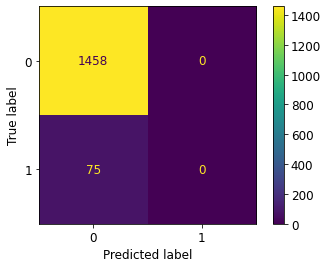

<class 'AttributeError'>
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
model best f1 score:  0.5041603117017732
{'clf__degree': 1, 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'poly__degree': 1}
model test score:  0.9302022178734507
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1479
           1       0.15      0.20      0.17        54

    accuracy                           0.93      1533
   macro avg       0.56      0.58      0.57      1533
weighted avg       0.94      0.93      0.94      1533



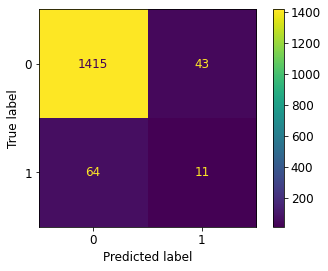

<class 'AttributeError'>
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
model best f1 score:  0.5013865546218488
{'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 5, 'clf__weights': 'uniform', 'poly__degree': 1}
model test score:  0.9510763209393346


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1533
           1       0.00      0.00      0.00         0

    accuracy                           0.95      1533
   macro avg       0.50      0.48      0.49      1533
weighted avg       1.00      0.95      0.97      1533



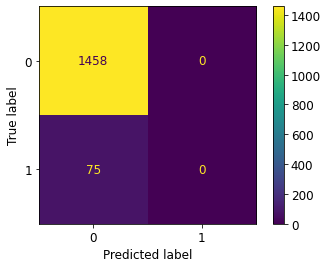

<class 'AttributeError'>
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
model best f1 score:  0.7810783696738608
{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': 14, 'clf__min_samples_leaf': 8, 'poly__degree': 1}
model test score:  0.7012393998695369
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1030
           1       0.80      0.12      0.21       503

    accuracy                           0.70      1533
   macro avg       0.75      0.55      0.51      1533
weighted avg       0.73      0.70      0.62      1533



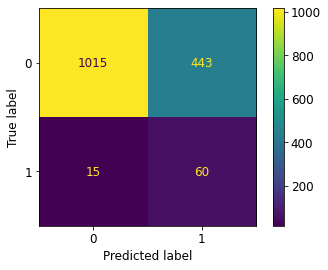

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
from sklearn.svm import LinearSVC
classifiers = [
    LogisticRegression(),
    SVC(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LinearSVC()
    ]

# LogisticRegression()
params1 = {
     'clf__C': [0.001, 0.01, 0.1, 1, 10, 100], "clf__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], "clf__max_iter": [3000,3500],
           } 
# SVC
params2 = {"poly__degree": range(1,2,1),"clf__kernel":["rbf", "poly", "linear", "sigmoid"], "clf__gamma": ["auto", "scale"], 
           "clf__degree":range(1,6,1)}
# KNeighborsClassifier()
params3 = {"poly__degree": range(1,2,1),"clf__n_neighbors": range(4,10,1), "clf__weights": ["uniform", "distance"],
         "clf__algorithm": ['ball_tree', 'kd_tree']}
# MultinomialNB()
params4 = {"poly__degree": range(1,2,1),"clf__fit_prior": ['True', 'False'], "clf__alpha": np.arange(0.8,1.2,0.1)}
# DecisionTreeClassifier()
params5 = {"poly__degree": range(1,2,1),"clf__criterion":["gini", "entropy"], "clf__max_depth": range(14,18,1),
           "clf__min_samples_leaf": range(8,14,1), "clf__class_weight": ["balanced", {0:1,1:5}] }   
# RandomForestClassifier()
params6 = {"poly__degree": range(1,2,1),"clf__criterion":["gini", "entropy"], "clf__class_weight":["balanced", "balanced_subsample"], 
           "clf__max_depth": range(10,28,2), "clf__min_samples_leaf": range(5,12,1), "clf__n_estimators":range(50,150,50)} 
# AdaBoostClassifier()
params7 = {"poly__degree": range(1,2,1),"clf__learning_rate":np.arange(0.2,1.1,0.1), "clf__n_estimators":range(20,60,20),
         "clf__algorithm":["SAMME", "SAMME.R"]} 
# GradientBoostingClassifier()
params8 = {"poly__degree": range(1,2,1),"clf__loss":["deviance", "exponential"], 
           #"clf__learning_rate":[0.09,0.085,0.1], "clf__n_estimators":range(80,120,20),
           #"clf__min_samples_leaf": range(1,4,1), "clf__max_depth": range(5,15,1), 
           #"clf__max_features": ["auto", "sqrt", "log2"], "clf__validation_fraction":np.arange(0.01,0.2,0.05)
           }
params9 = {
        } 
parameters = [params1, params2, params3,  params5, params6, params7, params8, params9]
i = 0
for classifier in classifiers:
    print(classifier)
    pipe = Pipeline(steps=[('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l2", dual=False,max_iter=2000))),
                            ('scaler', StandardScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', classifier) # , return_train_score = True
                      ])
    # выбираем balanced_accuracy, а не accuracy, так как классы несбалансированы
    grid_cv = model_selection.GridSearchCV(pipe, parameters[i], scoring='recall_macro') 
    grid_cv.fit(x_train, y_train)
    print("model best f1 score: ", grid_cv.best_score_)    
    print(grid_cv.best_params_)
    model = grid_cv.best_estimator_
    print("model test score: ", model.score(x_test, y_test))

    y_pred = model.predict(x_test)
    print(classification_report(y_pred,y_test))
    plot_confusion_matrix(model, x_test, y_test, values_format='d')
    plt.show()
    try:      
      fig = go.Figure()
      fig.add_trace(go.Bar(x=x_test.columns,y = model['clf'].feature_importances_))
      fig.update_layout(title='Feature selection results',xaxis_title='Model',yaxis_title='F1 Score')
      fig.show()
    except AttributeError:
      print(AttributeError)

    i+=1

In [625]:
# RandomForestClassifier()
rfc = {"clf__criterion":["gini", "entropy"], "clf__class_weight":["balanced", "balanced_subsample"], 
           "clf__max_depth": range(6,12,2), "clf__min_samples_leaf": range(5,9,1), "clf__n_estimators":[50,100]} 
pipe = Pipeline(steps=[     ('scaler', MinMaxScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', RandomForestClassifier()) 
                      ])
grid_cv = model_selection.GridSearchCV(pipe, rfc, scoring='f1')
grid_cv.fit(x_train, y_train)
print("model best score: ", grid_cv.best_score_)    
print(grid_cv.best_params_)
model = grid_cv.best_estimator_

model best score:  0.25636931255172424
{'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 7, 'clf__n_estimators': 50}


In [ ]:
y_pred = model.predict(x_test)

In [ ]:
# посмотрим, какие случаи не предсказала  модель
real = pd.concat([x_test, y_test], axis=1)
pred = real.copy()
pred["stroke2"] = y_pred
print(pred.shape, real.shape)

pred = pd.concat([real, pred.stroke2], axis=1)
real = real[real.stroke == 1]
pred = pred[pred.stroke2 == 1]
print(pred.shape)

In [ ]:
pd.options.display.max_rows = 210
pred # 156

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=x_test.columns,y = model['clf'].feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes On Our Prediction',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

In [ ]:
print(classification_report(y_pred,y_test))

In [ ]:
plot_confusion_matrix(model, x_test, y_test, values_format='d')

In [ ]:
sns.countplot(x="stroke",data=dataset,hue='Age_categories')